# MNIST Classification with Sagemaker XGBoost

### Preparing the Environment

In [21]:
import os
import boto3
import re
import time
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

import pickle
import gzip
import numpy as np
import urllib.request
import json
import matplotlib.pyplot as plt

In [22]:
role = get_execution_role()
region = boto3.Session().region_name
bucket = 'xgboost-mnist-202010'

In [23]:
prefix = 'sagemaker/DEMO-xgboost-mnist'
bucket_path = 's3://{}/{}'.format(bucket, prefix)

### Loading the data

In [24]:
urllib.request.urlretrieve('http://deeplearning.net/data/mnist/mnist.pkl.gz', 'mnist.pkl.gz')

zip_file = gzip.open('mnist.pkl.gz', 'rb')
train, valid, test = pickle.load(zip_file, encoding='latin1')

zip_file.close()

In [25]:
print(train[0].shape, valid[0].shape, test[0].shape)

(50000, 784) (10000, 784) (10000, 784)


In [39]:
# Explore the data
%matplotlib inline

def plot_images(dataset):
    fig, axes = plt.subplots(2, 5, figsize=(5*1.5, 2*2))

    for i in range(10):
        ax = axes[i // 5, i % 5]
        img = dataset[0][i]
        img_size = img.reshape((28,28))

        ax.imshow(img_size, cmap='gray')
        ax.set_title('Label: {}'.format(dataset[1][i]))

    plt.tight_layout()
    plt.show()

# plot_images(train)

### Data Conversion and S3 Upload

In [7]:
s3 = boto3.resource('s3')

try:
    s3.create_bucket(Bucket=bucket, CreateBucketConfiguration={ 'LocationConstraint' : region })
    
    print('S3 bucket created successfully')
    
except Exception as e:
    print('S3 error: ', e)

S3 error:  An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [27]:
data_partitions = [('train', train), ('validation', valid), ('test', test)]

for partition_name, partition_data in data_partitions:
    features = [f.tolist() for f in partition_data[0]]
    labels = [l.tolist() for l in partition_data[1]]
    
    if partition_name != 'test':
        samples = np.insert(features, 0, labels, axis=1)
    else:
        samples = features
    
    np.savetxt('data.csv', samples, delimiter=',')
    
    key = '{}/{}/{}.csv'.format(prefix, partition_name, partition_name)
    boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
    print('Successfully wrote to {}'.format(key))

Successfully wrote to sagemaker/DEMO-xgboost-mnist/train/train.csv
Successfully wrote to sagemaker/DEMO-xgboost-mnist/validation/validation.csv
Successfully wrote to sagemaker/DEMO-xgboost-mnist/test/test.csv


### Building the model

In [28]:
container = get_image_uri(region, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [31]:
train = bucket_path + '/train'
validation = bucket_path + '/validation'

s3_output = bucket_path + '/output'

In [32]:
model = sagemaker.estimator.Estimator(container,
                                      role,
                                      train_instance_type='ml.m4.xlarge',
                                      train_instance_count=1,
                                      train_volume_size=5,
                                      output_path=s3_output,
                                      sagemaker_session = sagemaker.Session()
                                     )

model.set_hyperparameters(max_depth=5,
                          eta=.2,
                          gamma=4,
                          min_child_weight=6,
                          silent=0,
                          objective='multi:softmax',
                          num_class=10,
                          num_round=10
                         )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [34]:
train_channel = sagemaker.session.s3_input(train, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [35]:
model.fit(inputs=data_channels,
          logs=True
         )

2020-10-10 19:24:10 Starting - Starting the training job...
2020-10-10 19:24:12 Starting - Launching requested ML instances......
2020-10-10 19:25:29 Starting - Preparing the instances for training......
2020-10-10 19:26:19 Downloading - Downloading input data...
2020-10-10 19:27:06 Training - Downloading the training image...
2020-10-10 19:27:27 Training - Training image download completed. Training in progress.Arguments: train
[2020-10-10:19:27:27:INFO] Running standalone xgboost training.
[2020-10-10:19:27:27:INFO] File size need to be processed in the node: 1122.95mb. Available memory size in the node: 8484.61mb
[2020-10-10:19:27:27:INFO] Determined delimiter of CSV input is ','
[19:27:27] S3DistributionType set as FullyReplicated
[19:27:33] 50000x784 matrix with 39200000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-10-10:19:27:34:INFO] Determined delimiter of CSV input is ','
[19:27:33] S3DistributionType set as FullyReplicated
[19:27:35

### Deploy the model

In [58]:
xgb_predictor = model.deploy(initial_instance_count=1,
                             content_type='text/csv',
                             instance_type='ml.t2.medium'
                            )

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: xgboost-2020-10-10-19-24-09-905


---------------!

### Testing

In [53]:
test_path = bucket_path + '/test/test.csv'

s3.Bucket(bucket).download_file(os.path.join(prefix, 'test/test.csv'), 'test.csv')

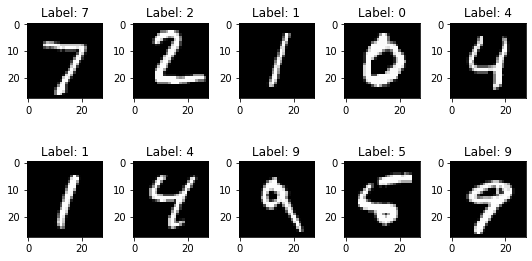

In [54]:
# Plot the first 10 images from test set and their true labels
plot_images(test)

In [124]:
# Predict
predictions = [list(), list()]

with open('test.csv', 'r') as file:
    for i in range(10):
        single_test = file.readline()
        prediction = xgb_predictor.predict(single_test)
        
        predictions[0].append(np.array(test[0][i]))
        predictions[1].append(int(float(prediction.decode('utf-8'))))

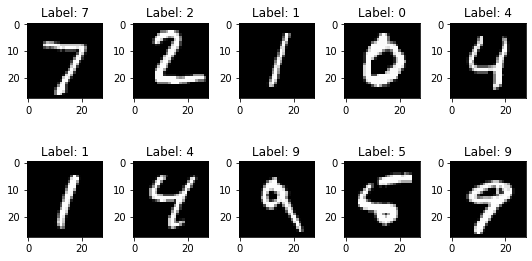

In [126]:
plot_images(predictions)